In [70]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16.,8.)

In [182]:
def form_discrete_values(funcs, y, orders):
    """ This function is used to present values of a model (Ferhulst for example)
        in an apropriate view of the table with first columns, referring to x, and lthe last one 
        to y. THE FUNCTION WORKS ONLY IN CASE STEP OF DISCRETIZATION IS 1 (any atempts aimed at fixing that
        caused a general formula to change (that is, each model would require its own discretization function
        that is shit, I reckon))
        @Parameters:
        1) funcs - contains an array of lambdas, to be applied to columns
        2) y - a column with output values
        3) orders - an array of integers, used to refer to lagging (for example, orders = 2, means, that
        the column is considered to be y[t - 2])"""
    x = np.array([[func(y[t - order, 0]) for func, order in zip(funcs, orders)] for t in range(orders[0], y.shape[0])])
    return np.hstack((x, y[orders[0]:]))


class Approximator(object):
    """ @Parameters:
        1) data - a table, where first columns are features and the last one is output
        2) teta - unknown parameters to be evaluated
        3) variance - unknown variance to be found
        This class is used to get linear approximation (using OMNK algo) and
        to calculate thereby variance, Akaike and Mallows coefficients"""
    def __init__(self, data):
        self.data = data
        self.teta = None
        self.variance = 0
        self.factors = None
        self.RMSs = 0
        self.RSSs = []
        self.Akaikes = []
        self.Mallowss = []
        
    def get_tetas(self, factors, is_ambiguous=False):
        """ @Parameters:
            1) factors - represents amount of factors to be accounter into (might not exceed the
            size of the self.data)
            This function implements OMNK algorithm, which recursively evaluates unknown coefficients
            by gradually adding columns to  X.T@X matrix and therefore requiring as much as there are
            columns present to complete. At the same time variance is also evalueted recursively"""
        if is_ambiguous:
            print("Step " + str(1) + " :")
        
        n, m = self.data.shape
        Hs = np.array([[(self.data[:, 0].T @ self.data[:, 0])]])
        h = np.array([[self.data[:, 0] @ self.data[:, 1]]])
        eta = np.array([[self.data[:, 0].T @ self.data[:, 0]]])
        Hs_inv = np.linalg.inv(Hs)
        teta = [self.data[:, :1].T @ self.data[:, -1] / (self.data[:, :1].T @ self.data[:, :1])]
        P = np.eye(n) - (self.data[:, :1] @ np.linalg.inv(self.data[:, :1].T 
                                          @ self.data[:, :1]) @ self.data[:, :1].T)   
        variance = self.data[:, -1].T @ P @ self.data[:, -1]

        for i in range(1, factors):
            self.factors = i
            self.variance = variance
            self.RSSs.append(variance)
            self.Akaikes.append(self.get_Akaike())
            self.Mallowss.append(self.get_Mallows())
            if is_ambiguous:
                print("Step " + str(i + 1) + " :")
            h = np.array([self.data[:, :i].T @ self.data[:, i]])
            eta = np.array([[self.data[:, i].T @ self.data[:, i]]])
            
            Hs_1 = Hs
            Hs_2 = h.T
            Hs_3 = h
            Hs_4 = eta
            beta = eta - h @ Hs_inv @ h.T
            D = np.eye(n) - self.data[:, :i] @ Hs_inv @ self.data[:, :i].T
            coefficient = self.data[:, i].T @ D @ self.data[:, i]
            
            Hs = np.hstack((np.vstack((Hs_1, Hs_3)), np.vstack((Hs_2, Hs_4))))
            
            Hs_inv_1 = Hs_inv + (1 / beta) * Hs_inv @ h.T @ h @ Hs_inv
            
            Hs_inv_2 = -(1 / beta) * Hs_inv @ h.T
            Hs_inv_3 = -(1 / beta) * h @ Hs_inv
            Hs_inv_4 = (1 / beta)
            
            Hs_inv = np.hstack((np.vstack((Hs_inv_1, Hs_inv_3)), np.vstack((Hs_inv_2, Hs_inv_4))))
            if is_ambiguous:
                print("HS_inv is: ")
                print(Hs_inv)
            gs = np.hstack((self.data[:, :i].T @ self.data[:, -1], self.data[:, i].T @ self.data[:, -1]))
            
            teta = Hs_inv @ gs
            variance -= (teta[-1] ** 2) * beta
            variance = variance[0][0]
            if is_ambiguous:
                print("parameters are: ")
                print(teta)
        self.teta = teta
        return teta
    
    def get_variance(self):
        return self.variance
    
    def get_sigma_evaluation(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance / (n - s)
    
    def get_Mallows(self):
        s = self.factors
        n, m = self.data.shape
        return self.variance / s ** 2 + (2 * s - n)
    
    """
    def get_Akaike(self):
        n, m = self.data.shape
        return self.variance * ((n + m)/ (n - m))
    """
    
    def get_Akaike(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance * ((n + s)/ (n - s))
    
    def get_params(self, formulas):
        params = list(map(lambda formula: formula(self.teta), formulas))
        return params

class Model:
    def __init__(self, system, name):
        self.system = system
        self.name = name
        self.solved = None
        self.time_points = None
        self.initial_condition = None
        self.params = None
    
    def get_values(self, step):
        data = self.solved[:, 0][::step]
        return data.reshape((data.shape[0], 1))
    
    def build(self, params, initial_condition, time_points):
        self.params = params
        self.time_points = time_points
        self.initial_condition = initial_condition
        self.solved = odeint(self.system, initial_condition, time_points, args=tuple(self.params.values()))
            
    def get_data(self, index):
        if index == 0:
            return pd.DataFrame({'t': self.time_points, 'X(t)': self.solved[:, 0]})
        if index == 1:
            return pd.DataFrame({'t': self.time_points, 'Y(t)': self.solved[:, 1]})
        else:
            return pd.DataFrame({'X': self.solved[:, 0], 'Y': self.solved[:, 1]})
    
    def plot(self, plot_y=True):
        plt.figure(0)
        plt.plot(self.time_points, self.solved[:, 0])
        if plot_y:
            plt.plot(self.time_points, self.solved[:, 1])
        params = re.findall("[^}'{']", str(re.sub(': ', '=', str(self.params))))
        plt.title(self.name + ' with params: \n' +  ''.join(params), fontsize=15)
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
    
    
    def phase_plot(self):
        plt.figure(1)
        plt.xlabel('X', fontsize=15)
        plt.ylabel('Y', fontsize=15)
        plt.scatter(self.solved[0,0], self.solved[0, 1])
        plt.plot(self.solved[:,0], self.solved[:, 1], color='orange')
        plt.title(self.name + ' ' + 'phase plot\n', fontsize=15)
        

In [180]:
import seaborn as sns
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst_params = {
    'r': 1., 
    'k': 5.
}

verhulst_initial_condition=(.1, 0)

class Verhulst_Approximator:
    def __init__(self, 
                 verhulst_params,
                 verhulst_initial_condition,
                 noise=9,
                 step= 0.05,
                 step_diff=10,
                 t_begin=0,
                 t_end=10
                ):
        self.verhulst_params = verhulst_params
        self.verhulst_initial_condition = verhulst_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 2, self.step / self.step_diff)
        self.data = self.extract_verhulst_features()
    
    def extract_verhulst_features(self):
        model = Model(Verhulst, 'Verhulst')
        model.build(self.verhulst_params, self.verhulst_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([self.verhulst_params['r'] * self.verhulst_params['k'] + 1/self.step, - self.verhulst_params['r']])
        data = {
            't': self.t[0::self.step_diff][:-1],
            'N(t)': out[0::self.step_diff][:-1],
            'N^2(t)': np.square(out[0::self.step_diff][:-1]), # 
            'N(t+{})'.format(self.step):  out[0::self.step_diff][1:] #np.round(np.array([out[0::100][:-1], np.square(out[0::100][:-1])]).T @ theta, self.noise)
        }
        return pd.DataFrame(data=data)
    
    def run(self):
        solver = Approximator(self.data.to_numpy()[:, 1:])
        tetas = solver.get_tetas(2)
        print(tetas)
        #er.get_variance()
        #mallows = solver.get_Mallows()
        #akaike = solver.get_Akaike()
        #print(variance, mallows, akaike)
        
        def findparams(theta1, theta2):
            r = - theta2 / self.step
            k = (1 - theta1) / theta2
            return {'r': r, 'k': k }
        
        pred_params = findparams(tetas[0], tetas[1])
        print(pred_params)
        model = Model(Verhulst, 'Verhulst')
        model.build(pred_params, self.verhulst_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        #plt.figure(1)
        sns.scatterplot(self.data['t'], self.data['N(t+{})'.format(self.step)], color='brown')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)

[ 1.24963492 -0.04994552]
{'r': 0.9989103358643092, 'k': 4.998144663784373}


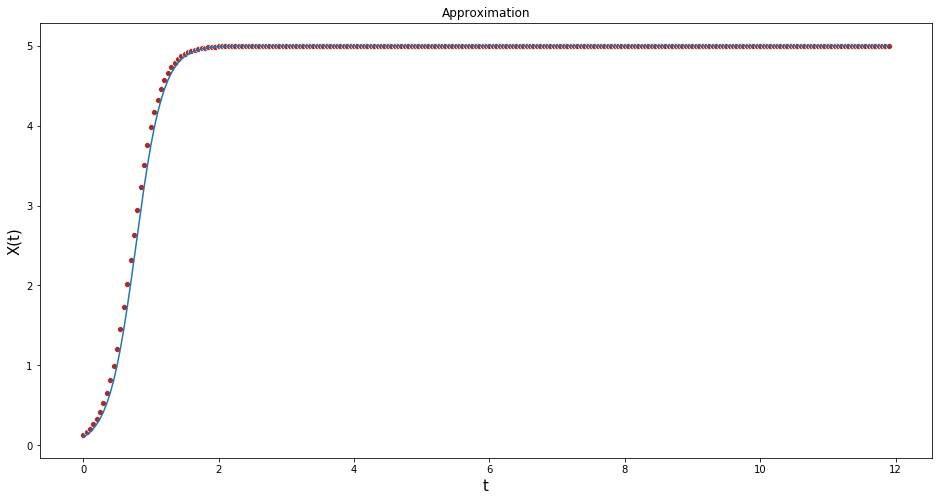

In [163]:
ver = Verhulst_Approximator(verhulst_params, verhulst_initial_condition)
ver.run()
#ver.data


In [164]:
import seaborn as sns
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt



class Oscilate_Approximator:
    def __init__(self, 
                 oscilate_params,
                 oscilate_initial_condition,
                 noise=8,
                 step=.1,
                 step_diff=100000,
                 t_begin=0,
                 t_end=30
                ):
        self.oscilate_params = oscilate_params
        self.oscilate_initial_condition = oscilate_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 3, self.step / self.step_diff)
        self.data = self.extract_oscilation_features()
    
    def extract_oscilation_features(self):
        model = Model(oscilation, 'Oscilation')
        model.build(self.oscilate_params, self.oscilate_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([(2 - 2 * self.oscilate_params['delta'] - (self.oscilate_params['omega']**2) * self.step**2) / 
                          (1 - 2 * self.oscilate_params['delta'] * self.step),
                         1 / (2 * self.oscilate_params['delta'] * self.step - 1)])
        data = {
            't': self.t[0::self.step_diff][:-2],
            'x(t)': out[0::self.step_diff][:-2],
            'x(t+{})'.format(self.step):  out[0::self.step_diff][1:-1],
            'x(t+{})'.format(self.step*2):  out[0::self.step_diff][2:] # np.round(np.array([out[0::step*100][:-1], out[0::step*100][1:]]).T @ theta, noise)
        }
        return pd.DataFrame(data=data)

    def run(self):
        solver = Approximator(self.data.to_numpy()[:,1:])
        #print(self.data.to_numpy()[:,1:])
        tetas = solver.get_tetas(2)
        
        #variance = solver.get_variance()
        #mallows = solver.get_Mallows()
        #akaike = solver.get_Akaike()
        #print(variance, mallows, akaike)
        
        def findparams(theta2, theta1):
            delta =  ((1 / theta2) + 1) / (2 * self.step)
            omega = np.sqrt(((-1*theta1 * (1 - 2 * delta * self.step) + 2 - 2 * delta) / self.step**2)) 
           
            return {'delta': delta, 'omega': omega, 'omega_0': 0., 'f': 0.}
        
        pred_params = findparams(tetas[0], tetas[1])
        print(pred_params)
        model = Model(oscilation, 'Oscilation')
        model.build(pred_params, self.oscilate_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        #plt.figure(1)
        sns.scatterplot(self.data['t'], self.data['x(t+{})'.format(self.step*2)], color='black')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)

{'delta': -0.01000999519318202, 'omega': 1.4324793741296225, 'omega_0': 0.0, 'f': 0.0}


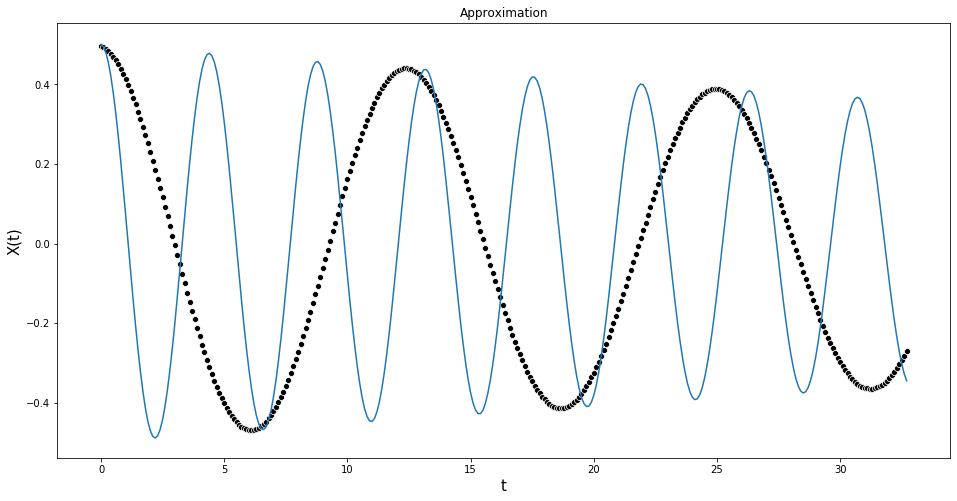

In [165]:
oscilate_params = {
    'delta': -0.01, 
    'omega':0.5,
    'omega_0': 0.,
    'f': 0.
}

oscilate_initial_condition=(0.5,0.)



osc = Oscilate_Approximator(oscilate_params, oscilate_initial_condition)
osc.run()


In [166]:
class Generator:
    def __init__(self, n, noise=0.01, theta=np.array([-2, 1.2, 1.44, -1, 0.01, 0,0,0,1,0])):
        self.X = np.random.uniform(0, 10, (n, theta.shape[0]))
        self.theta = theta
        self.noise = np.random.normal(0, noise, n)
        self.y = self.X @ self.theta + self.noise
    
    def run(self):
        print('n = {}'.format(self.noise.shape[0]))
        print('noise = {}'.format(0.01))
        print('X:{}'.format(self.X))
        print('y:{}'.format(self.y))
        solver = Approximator(np.vstack((self.X.T, self.y.T)).T)
        tetas = solver.get_tetas(self.X.shape[1], False)
        plt.plot(solver.RSSs, color = 'black')
        plt.plot(solver.Akaikes)
        plt.plot(solver.Mallowss)
        plt.legend(['RSS', 'Kakaike', 'Mallowss'])
        plt.title('Task Generator')
        print('True values: θ = {}'.format(self.theta))
        print('Estimates: θ* = {}'.format(tetas))
 

n = 5
noise = 0.01
X:[[2.35136751 3.66847103 2.31028103 6.57963566 5.18818566]
 [8.18348947 3.40660388 6.84196714 6.62403581 3.61879006]
 [4.38268093 0.98318495 9.76054431 9.82670312 9.99490454]
 [3.757054   2.19096071 4.02940716 0.23782784 3.85899582]
 [8.24643781 3.66001323 0.81885297 2.00823754 5.09466432]]
y:[ 2.0257211  24.58393395 20.93300863 10.91550755 18.24961691]
True values: θ = [ 3. -2.  1.  0.  0.]
Estimates: θ* = [ 3.00224317e+00 -2.00090310e+00  9.98237332e-01  5.96431805e-04
 -6.81157579e-04]


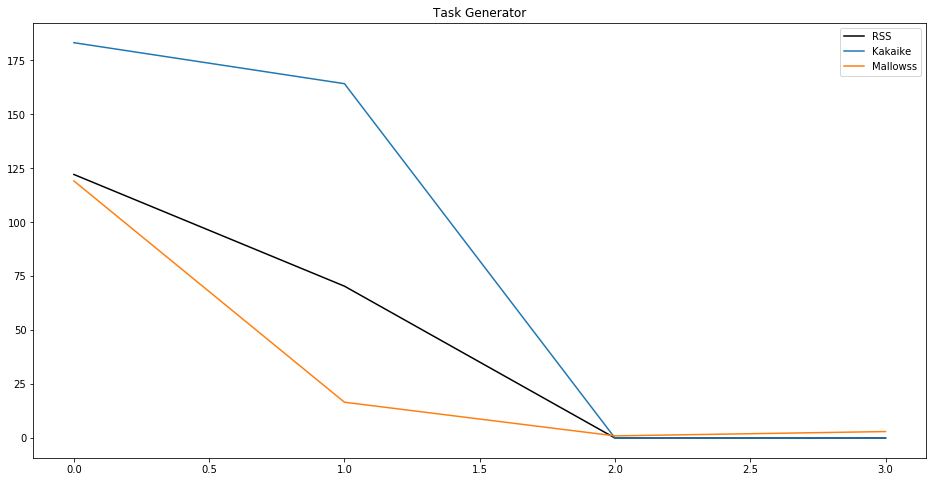

In [198]:
Generator(5, theta = np.array([3.,-2.,1.,0.,0.])).run()